# Demand Prediction 
## DSE203
## Machine Learning Team

### This is the generic workflow for the Gradient Boosted Regression Model we'll use to predict the number of sales for a given category in the next month for our bookstore. 

We believe we'll need at least 3 flavors of the model: 

+ Invariant - Categories of books that never seem to fluctuate in sales over time
+ Seasonally Invariant - Categories of books that seem to only increase over certain months in the year
+ "Other" - Categories of books where sales variance doesn't readily follow a pattern. We hope that EDA will help us explore whether there are sub-clusters of this flavor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import ensemble

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## We don't currently have the data pulled from the model so let's use a generated set of data to demonstrate the analysis pipeline.

In [3]:
from sklearn.datasets import make_regression, make_friedman1
from sklearn.preprocessing import StandardScaler

def generate_dataset(n_train, n_test, n_features, noise=0.1, verbose=False):

    X, y = make_friedman1(n_samples=n_train + n_test, noise=0.1, random_state=816)

    random_seed = 816
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_train, test_size=n_test, random_state=random_seed)

    return X_train, y_train, X_test, y_test

In [4]:
n_train = 15000
n_test = 3000
n_features = 11

X_train, y_train, X_test, y_test = generate_dataset(n_train, n_test, n_features)

# Fit the model to the training data

Here we use Gradient Boosted Regression trees with a max tree depth of 4 and minimum samples in a leaf for a split of 2. The learning rate is 0.01. 

There is a parameter called 'init' which is supposed to pass in any previously-trained regression model. The idea is that every time we train the model, then we can use the previously trained model as the starting point for the new model. Therefore, the only data we need to access is the data that was not included in the previous models. This will greatly help in scalability of the system. NOTE: There seems to be some current bug in sklearn for this. I believe XGBoost has the same procedure for performing online, batch updates of the regression model.

In [5]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'huber'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

# Evaluate the model against the test data

Mean squared error = 1.0155
r-squared = 0.957


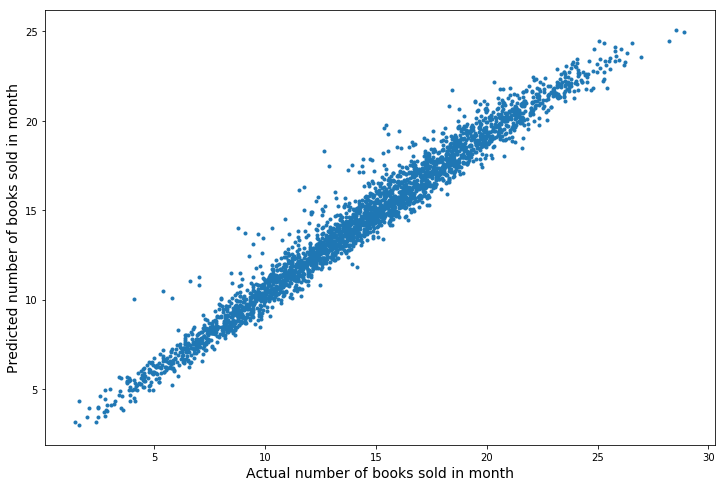

In [6]:
mse = mean_squared_error(y_test, clf.predict(X_test))

from sklearn.metrics import r2_score

plt.figure(figsize=(12,8))
plt.plot(y_test, clf.predict(X_test), '.')
plt.xlabel('Actual number of books sold in month', fontsize=14)
plt.ylabel('Predicted number of books sold in month', fontsize=14)
print('Mean squared error = {:.4f}'.format(mse))
print('r-squared = {:.3f}'.format(r2_score(y_test, clf.predict(X_test))))

# Training and Testing Mean Squared Error as a function of Iteration

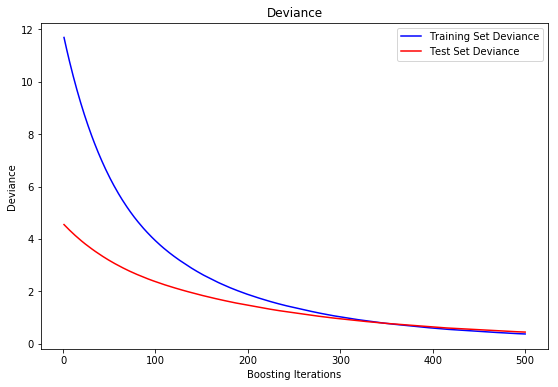

In [7]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

# Relative Importance of Different Features

This approach will allow us to weight the relative importance of different features to the regression.  This will help us to explain the model to the client in relatively simple terms. For example, we can say things like "The important features to predicting the number of sales are price, recent sentiment about the book, and the last 4 months of sales."

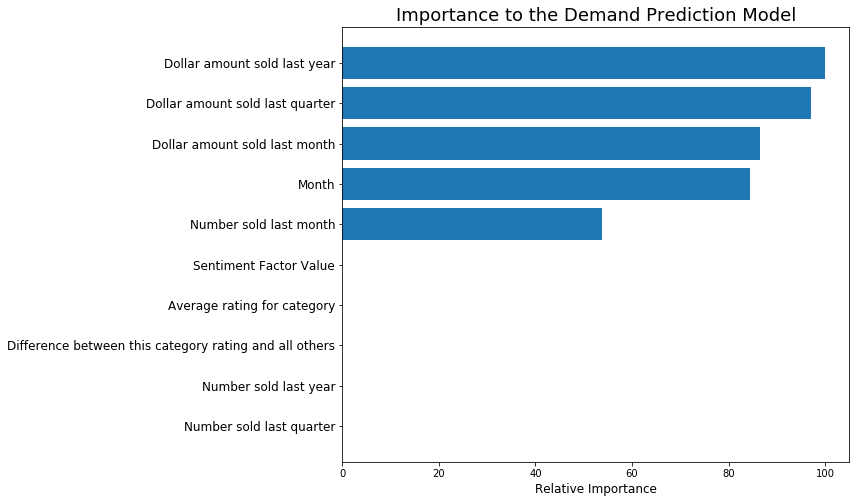

In [8]:

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

labels = np.array(['Month', 'Dollar amount sold last month', 'Dollar amount sold last quarter', 'Dollar amount sold last year', 
         'Number sold last month', 'Number sold last quarter', 'Number sold last year',
         'Average rating for category', 'Difference between this category rating and all others',
         'Sentiment Factor Value', 'Is in Campaign?'])

plt.yticks(pos, labels[sorted_idx], fontsize=12)
plt.xlabel('Relative Importance', fontsize=12)
plt.title('Importance to the Demand Prediction Model', fontsize=18)
plt.show()